In [1]:
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.core.registries import line_registry
from astropy.modeling.fitting import LevMarLSQFitter
from spectacle.process.lsf import LSF

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from uncertainties import unumpy as unp

INFO:root:Added misty to custom loaders.
INFO:root:Added my-format to custom loaders.


In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 8]

# Identify and parameterize real data
This is an example notebook of taking some real data and fitting an absorption feature. It is very basic, and uses all the default settings.

## Load data
Load the data. The fitter currently assumes that all data has been normalized to 1.

In [3]:
# Set the line list to use
line_registry.read("/Users/nearl/projects/spectacle/spectacle/data/line_list/atoms.ecsv")

In [4]:
# Load real data
with fits.open("/Users/nearl/projects/hst_proposal/QSOALS/3C066A/3C066A_coadd_FUVM_final_all.fits") as hdulist:
    disp, flux, uncert, dq = hdulist[1].data['WAVE'], hdulist[1].data['FLUX'], \
                             hdulist[1].data['ERROR'], hdulist[1].data['DQ']

In [5]:
# Create a mask and apply it since we don't really care about the entire spectrum
# mask = [(disp > 1276) & (disp < 1283)]
mask = [(disp > 1250) & (disp < 1300)]

flux = flux[mask]
disp = disp[mask]
uncert = uncert[mask]

# Currently, the fitting assumes that the data is normalized to 1.0
tmp_flux = unp.uarray(flux, uncert)
tmp_flux /= np.median(tmp_flux)
flux, uncert = unp.nominal_values(tmp_flux), unp.std_devs(tmp_flux)

# Create spectrum object
spectrum = Spectrum1D(flux, dispersion=disp, uncertainty=uncert)

## Find some lines and create Absorption1D model

Note that `strict=True` means that only lines that exist in the line list will be found.

In [6]:
found_lines = spectrum.find_lines(threshold=0.15, min_dist=25, strict=True)
spec_mod = Absorption1D(lines=found_lines)

/Users/nearl/anaconda3/envs/spec_env/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
INFO:root:Found 13 lines.
INFO:root:Found SI1296 (1295.6531) at 1295.6547110520303. Strict is True.
INFO:root:Found SII1260 (1259.519) at 1259.5148815348746. Strict is True.
INFO:root:Found SII1254 (1253.811) at 1253.8154102131725. Strict is True.
INFO:root:Found SII1251 (1250.584) at 1250.587038345635. Strict is True.
INFO:root:Found CI1261 (1260.7351) at 1260.730503040552. Strict is True.
INFO:root:Found SiII1260 (1260.4221) at 1260.4216156087816. Strict is True.
INFO:root:Found CI1276 (1276.4822) at 1276.483762060851. Strict is True.
INFO:root:Found CI1277 (1277.245) at 1277.2410344742239. Strict is True.
INFO:root:Found CI1280 (1280.13

Using strict line associations.


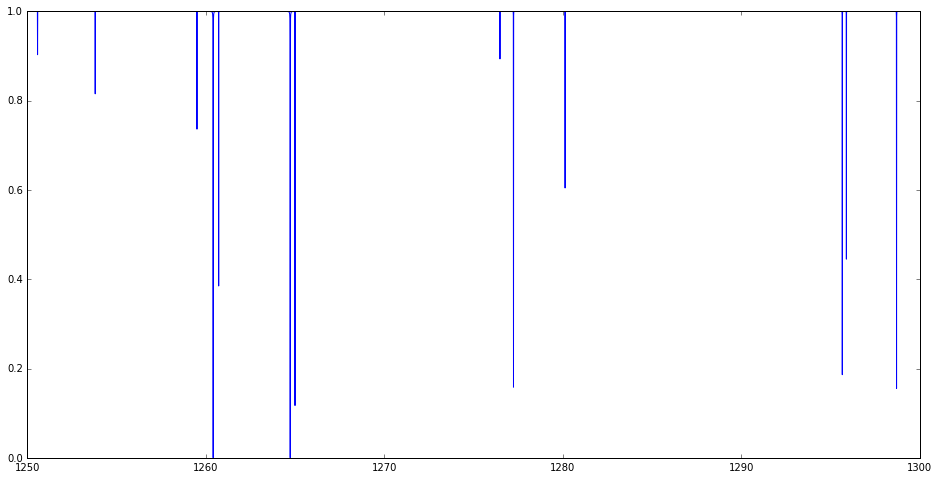

In [7]:
# Check out the results. Calling the mode with a dispersion array returns a `Spectrum1D` object
y = spec_mod(spectrum.dispersion)

# Plot the results
f, (ax1) = plt.subplots()

ax1.plot(y.dispersion, y.data)

## Create `Fitter`
The `Fitter` object encapsulates the method of fitting, along with the line identifying and detrending routines. Certain parameters, like the distance between identified lines, and the noise level can also be set.

In [8]:
# Create a fitter. The default fitting routine is a LevMarLSQ.
fitter = LevMarLSQFitter()

fit_spec_mod = fitter(spec_mod, spectrum.dispersion, spectrum.data, maxiter=500)
fitter.fit_info['message']

/Users/nearl/projects/spectacle/spectacle/modeling/models.py:33: RuntimeWarning: overflow encountered in exp
  flux = np.exp(-profile.optical_depth) - 1.0


'Number of calls to function has reached maxfev = 500.'

<IPython.core.display.Javascript object>


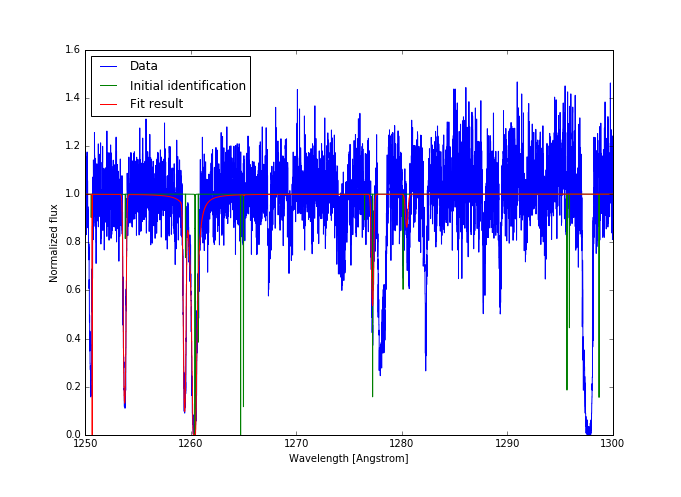

In [15]:
%matplotlib notebook
# Call the absorption model with a dispersion array to get a `Spectrum1D` object
fit_y = fit_spec_mod(spectrum.dispersion)

# Plot the results
f, (ax1) = plt.subplots()

ax1.step(spectrum.dispersion, spectrum.data, label="Data")
ax1.step(y.dispersion, y.data, label="Initial identification")
ax1.step(fit_y.dispersion, fit_y.data, label="Fit result")

ax1.set_xlabel("Wavelength [Angstrom]")
ax1.set_ylabel("Normalized flux")

plt.legend(loc=0)

Let's get some first- and second-order information out of this.

In [10]:
print("Equivalent width: {}".format(fit_y.equivalent_width()))
print("Centroid: {}".format(fit_y.centroid(1260)))

Equivalent width: (1.0786683888539913e-05, 0.0)
Centroid: (array(1260.4101508512895), array(0.0))


In [11]:
print(fit_spec_mod["TiIII1299"])
fit_y.equivalent_width(fit_spec_mod["TiIII1299"].lambda_0.value)

ERROR:root:index 0 is out of bounds for axis 0 with size 0


Model: Line
Name: TiIII1299
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       lambda_0   f_value    gamma    ... column_density delta_v delta_lambda
    ------------- ------- ----------- ... -------------- ------- ------------
    1298.51722878  0.0964 635000000.0 ...   10.254937238     0.0          0.0


(1.5374894812407742, 0.0)